In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Import the adfuller function from the statsmodels module
from statsmodels.tsa.stattools import adfuller

# Import the modules for plotting the sample ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import the module for estimating an ARMA model
from statsmodels.tsa.arima_model import ARMA

# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima_model import ARIMA

In [3]:
df = pd.read_csv('../../data/household_power_consumption.txt',
                 sep=';',na_values = '?')

# Retaining data only from year 2010
df = df[df['Date'].isin([s for s in df['Date'].values if '2010' in s])].reset_index(drop=True)

# Removing all null rows
df = df.loc[df[df.isnull().sum(axis=1) == 0].index,:]

# Converting Date and Time columns into a datetime object and setting that as th index
df['Datetime'] = df.apply(lambda x: ' '.join([x['Date'],x['Time']]),axis=1)
df.index = pd.to_datetime(df['Datetime'],format='%d/%m/%Y %H:%M:%S')
df['Datetime'] = pd.to_datetime(df['Datetime'],format='%d/%m/%Y %H:%M:%S')
df.index.name = 'datetime'
df.drop(labels = ['Date','Time'],axis=1,inplace = True)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
datetime,,,,,,,,
2010-01-01 00:00:00,1.790,0.236,240.65,7.4,0.0,0.0,18.0,2010-01-01 00:00:00
2010-01-01 00:01:00,1.780,0.234,240.07,7.4,0.0,0.0,18.0,2010-01-01 00:01:00
2010-01-01 00:02:00,1.780,0.234,240.15,7.4,0.0,0.0,19.0,2010-01-01 00:02:00
2010-01-01 00:03:00,1.746,0.186,240.26,7.2,0.0,0.0,18.0,2010-01-01 00:03:00
2010-01-01 00:04:00,1.686,0.102,240.12,7.0,0.0,0.0,18.0,2010-01-01 00:04:00


## Case Study: Global Active Power (GAP)

### Analyzing GAP
- Convert index to datetime object.
- Plot the data
- Test for Random Walk using Dickey-Fuller Test
- Take first differences to make it a stationary series
- Compute the ACF and PACF
- Fit a few AR, MA, and ARMA models
- Use Information Criterion to choose best model
- Forecast temperature over next 30 days

In [10]:
data = df[['Global_active_power']]
# Resample down to dailty average reading
data = data.resample(rule = '1D').mean()
# Fill missing values with forward-fill method
data.fillna(method='ffill',inplace=True)

<AxesSubplot:xlabel='datetime'>

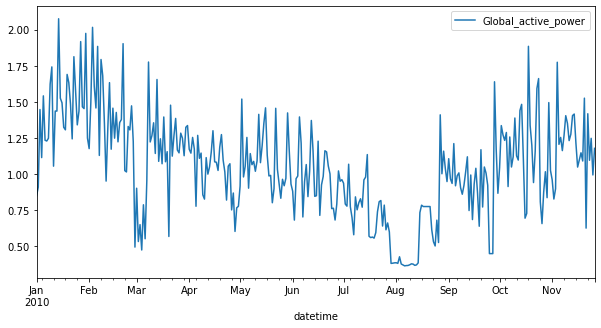

In [11]:
data.plot(figsize=(10,5))

In [15]:
# Lets split the data into train and test set.
train = data[:-30]
test = data[-30:]

### Is GAP is Random Walk?

In [18]:
# Compute and print ADF p-value
result = adfuller(train['Global_active_power'])
print("The p-value for the ADF test is ", result[1])
print("Since there is no enough evidence against the null, GAP is a Random Walk.")

The p-value for the ADF test is  0.2292036162489689
Since there is no enough evidence against the null, GAP is a Random Walk.


### Look at Autocorrelations

Since the GAP is a random walk with long term drifts, take first difference to make is stationary. Then compute the sample ACF and PACF. This will provide some guidance on the order of the model.

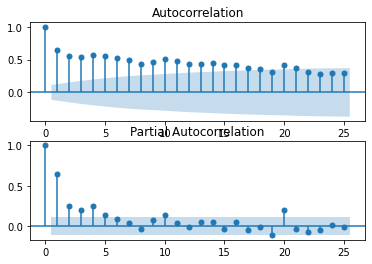

In [23]:
chg_train = train.diff()
chg_train = train.dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
_=plot_acf(chg_train, lags=25, ax=axes[0])

# Plot the PACF
_=plot_pacf(chg_train, lags=25, ax=axes[1])

From the PACF plot, there seems to be as lag-4 autocorrelation

### Which ARMA Model is best?

Recall from Chapter 3 that the Akaike Information Criterion (AIC) can be used to compare models with different numbers of parameters. It measures goodness-of-fit, but places a penalty on models with more parameters to discourage overfitting. Lower AIC scores are better.

Fit the train GAP data to an AR(1), AR(2), and ARMA(1,1) and see which model is the best fit, using the AIC criterion. The AR(2) and ARMA(1,1) models have one more parameter than the AR(1) has.

In [25]:
# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARMA(chg_train, order=(1, 0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC:
mod_ar2 = ARMA(chg_train, order=(2, 0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod_arma11 = ARMA(chg_train, order=(1, 1))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)

The AIC for an AR(1) is:  71.77953292517088
The AIC for an AR(2) is:  55.822078823452216
The AIC for an ARMA(1,1) is:  26.849550203227977


The ARMA(1,1) has the lowest AIC values among the three models

### Forecasting GAP for the next 30 days

Finally, you will forecast the GAP over the next 30 days using an ARMA(1,1) model, including confidence bands around that estimate. Keep in mind that the estimate of the drift will have a much bigger impact on long range forecasts than the ARMA parameters.

Earlier, you determined that the GAP data follows a random walk and you looked at first differencing the data. In this exercise, you will use the ARIMA module on the GAP data (before differencing), which is identical to using the ARMA module on changes in temperature, followed by taking cumulative sums of these changes to get the temperature forecast.

<Figure size 1440x360 with 0 Axes>

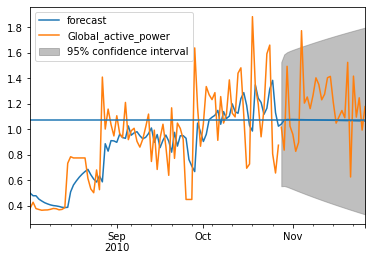

In [74]:
# Forecast GAP using an ARIMA(1,1,1) model
mod = ARIMA(train, order=(1,1,1)) # The d in order(p,d,q) is one, since we first differenced once
res = mod.fit()

# Plot the original series and the forecasted series
plt.figure(figsize=(20,5))
ax = res.plot_predict(start='2010-08-02', end='2010-11-26')
plt.plot(test,color='C01')
plt.axhline(1.07)
plt.show()

According to the model, the GAP is expected to be around 1.07 in the next 30 days, but the 95% CI around that is over 1.2.